# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

**Answer:**
Whether a problem is a classification problem or a regression one is sometimes very subjective. However, it's common to treat a problem as a classification one when the output we are looking for is discrete and within a finite range, and a regression one when it's continuous and in an open range. In our case, we are trying to determine whether a student belongs to the "class" of need intervention or not. The output is therefore discrete/finite (0 or 1). So I would be more prone to treat this as a classfication problem.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
from __future__ import division

# student_data.head()
# student_data.describe()
# colnames = list(student_data.columns.values)

n_students = student_data.shape[0]
n_features = student_data.iloc[:, 0:-1].shape[1]
n_passed = student_data[student_data['passed'] == 'yes'].shape[0]
n_failed = student_data[student_data['passed'] == 'no'].shape[0]
grad_rate = (n_passed / n_students) * 100

print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


# 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
student_data.iteritems()

<generator object iteritems at 0x10ad412d0>

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [50]:
from sklearn import cross_validation
from sklearn import linear_model
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, train_size=num_train)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

**What are the general applications of this model? What are its strengths and weaknesses?**

**Answer:** 

- **Logistic Regression:** Logistic regression is used widely for tackling classification problems. The strength of the model is that it is relatively cheap to train and test. The problem with Logistic Regression is that it converges to any decision boundary that can divide the training examples into positive and negative classes and therefore generally not as "optimized" as SVM.

- **Adaboost:** Adaboost is a very popular ensemble method that works well on most classifiers. It's strengh is in that it doesn't require its base learner to have strong predicting power to get good results and is less likely to overfit. The downside of Adaboost is that it may try too hard to correctly classify the training examples so may not be the best choise for dealing with noisy data.

- **SVM:** Similar to Logistic Regression, SVM has now become probably the most popular classification algorithm due to its ability to maximize the margin of the label classes. SVM is in many way similar to Logistic Regression. However, its cost function is defined slightly differently to that of Logistic Regression, to maximize the margin which makes SVM relatively more "robust" compared to Logristic Regression. The downside of SVM is that it's relatively more expensive to train.

**Given what you know about the data so far, why did you choose this model to apply?**

**Answer:** 

- **Logistic Regression:**
    1. It's a relatively simpler model which gives me an idea of sort of the lower bound of my accuracy.
    2. The fact that it may not be a very sophisticated model makes it the perfect candidate as a weak learner, which later can be fed into my boosting algorithm.
    3. It's relatively cheaper to train so since this project is under a budget, it may turn out that it's good enough comparing to other more compuatationally expensive models and being the perfect choice for our task.

- **Adaboost:**
    1. Boosting generally works very well with very simple base learners, and with simple base learners and reasonable number of estimators, it's generally not very expensive to train.
    2. It's less likely to overfit.
    
- **SVM:**
    1. SVM generally works very well as a standalone classifier, given it's nature.
    2. It's generally considered a "better" version of Logistic Regression. Knowing the lower bound, I'd like to experiment and compare their results and see how they differ from each other.

In [21]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
clf = linear_model.LogisticRegression(penalty='l2', solver='lbfgs')

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it


Training LogisticRegression...
Done!
Training time (secs): 0.038
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


In [22]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.851936218679


In [23]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.807947019868


In [31]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

# Make the training set smaller while using the same test set as before
## |Training set| = 300
train_predict(clf, X_train, y_train, X_test, y_test)

## |Training set| = 200
X_tr200, X_t200, y_tr200, y_t200 = cross_validation.train_test_split(X_train, y_train, train_size=200, random_state=0)
train_predict(clf, X_tr200, y_tr200, X_test, y_test)

## |Training set| = 100
X_tr100, X_t100, y_tr100, y_t100 = cross_validation.train_test_split(X_train, y_train, train_size=100, random_state=0)
train_predict(clf, X_tr100, y_tr100, X_test, y_test)

------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.032
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.851936218679
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.807947019868
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.031
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.862745098039
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.818181818182
------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.029
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.91156462

In [28]:
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

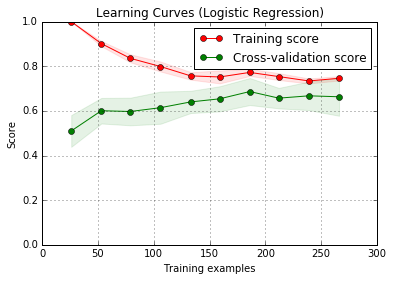

In [39]:
# Logistic Regression Learning Curve
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(clf, title, X_train, y_train, cv=9, n_jobs=1, ylim=(0, 1), train_sizes=np.linspace(.1, 1.0, 10))

plt.show()

![L-Reg Table](./L-Reg.png)

In [43]:
# TODO: Train and predict using two other models
from sklearn import grid_search
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer

# Adaboost + L-regression
f1_scorer = make_scorer(f1_score, pos_label='yes')
parameters = {"n_estimators": range(1, 5)}

ens_clf = AdaBoostClassifier(base_estimator=clf, learning_rate=1.0, algorithm='SAMME.R', random_state=0)
ens_gs = grid_search.GridSearchCV(ens_clf, parameters, scoring=f1_scorer)
ens_gs.fit(X_train, y_train)
y_pred = ens_gs.predict(X_test)

print ens_gs.best_params_

## |Training set| = 300
train_predict(ens_gs, X_train, y_train, X_test, y_test)

## |Training set| = 200
X_tr200, X_t200, y_tr200, y_t200 = cross_validation.train_test_split(X_train, y_train, train_size=200, random_state=0)
train_predict(ens_gs, X_tr200, y_tr200, X_test, y_test)

## |Training set| = 100
X_tr100, X_t100, y_tr100, y_t100 = cross_validation.train_test_split(X_train, y_train, train_size=100, random_state=0)
train_predict(ens_gs, X_tr100, y_tr100, X_test, y_test)

{'n_estimators': 3}
------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 0.535
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.81390593047
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.807947019868
------------------------------------------
Training set size: 200
Training GridSearchCV...
Done!
Training time (secs): 0.367
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.810810810811
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.792207792208
------------------------------------------
Training set size: 100
Training GridSearchCV...
Done!
Training time (secs): 0.351
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.784810126582
Predicting labels using 

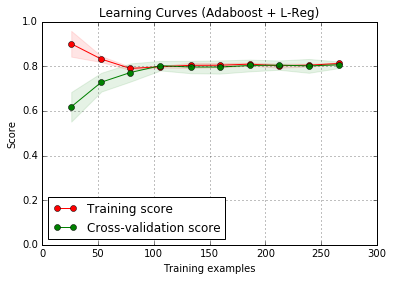

In [40]:
title = "Learning Curves (Adaboost + L-Reg)"
plot_learning_curve(ens_gs, title, X_train, y_train, cv=9, n_jobs=1, ylim=(0, 1), train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

![L-Reg Table](./LR-Boosted.png)

In [34]:
# SVM
from sklearn import svm
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
svc_gs = grid_search.GridSearchCV(svc, parameters, cv=9, scoring=f1_scorer)
svc_gs.fit(X_train, y_train)
y_pred = svc_gs.predict(X_test)

## |Training set| = 300
train_predict(svc_gs, X_train, y_train, X_test, y_test)

## |Training set| = 200
X_tr200, X_t200, y_tr200, y_t200 = cross_validation.train_test_split(X_train, y_train, train_size=200, random_state=0)
train_predict(svc_gs, X_tr200, y_tr200, X_test, y_test)

## |Training set| = 100
X_tr100, X_t100, y_tr100, y_t100 = cross_validation.train_test_split(X_train, y_train, train_size=100, random_state=0)
train_predict(svc_gs, X_tr100, y_tr100, X_test, y_test)

------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 5.216
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.005
F1 score for training set: 0.870897155361
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.830188679245
------------------------------------------
Training set size: 200
Training GridSearchCV...
Done!
Training time (secs): 4.342
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.87417218543
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.83660130719
------------------------------------------
Training set size: 100
Training GridSearchCV...
Done!
Training time (secs): 0.539
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.8625
Predicting labels using GridSearchCV...
Done!
Predict

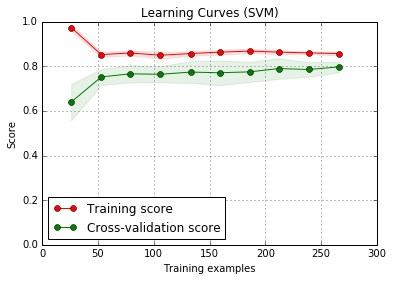

In [41]:
title = "Learning Curves (SVM)"
plot_learning_curve(svc_gs, title, X_train, y_train, cv=9, n_jobs=1, ylim=(0, 1), train_sizes=np.linspace(.1, 1.0, 10))
plt.show()


![L-Reg Table](./SVM.png)

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

**Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?**

**Answer:** Based on the experiments, I'd consider the Boosted Logistic Regression as the most suitable one for our task, for the following reasons:

1. It's reasonably cheap (computationally) to train (compared to SVM) and very cheap to test (not instance-based). The boosting part only uses three 3 estimators to achieve this.
2. It dosesn't need a lot of data to train. If you look at the training curve, you'll see it goes up extremely fast in terms of accuracy (F1 score, that is), for the cross-validation set.
3. It's an eager learner algorithm which means it doesn't take up much memory (space). The only things it needs to store in the memory are the learned parameters.

**In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).**

**Answer:**

Our learning algorithm is made of two parts:

1. **The weak learner:** we use Logistic Regression as our *weak learner* (as to what weak learner means will be explained later). It's similar to linear regression where we assign a weight to each of the features/attributes in the dataset, and determine an error metric. And for each observation (student) we feed to our algorithm we get an error, large or small, or zero. For different sets of weights we get different errors, so we use Calculus to find the set of weights that minimizes the sum of errors (over the entire training dataset).

2. **Boosting:**

    The boosting algorithm works like this:

    1. We take our weak learner algorithm to make some rough predictioins on the validation set. "Weak" here means we don't have high expectation for it to perform well but only requiring it to perform better than random guesses.

    2. In the first iteration, we use this weak learner to make predictions on all the observations (students), and see which ones we got wrong.

    3. In the second iteration, we take another weak learner, but this time we train "harder" on those observations that we got wrong.

    4. Continue doing so and we get a bunch of weak learners focusing on differet subsets of students.

    5. We sum up all the learners to get the ultimate superpositioned learner which contains learners of different "expertise", with each focusing on differert "type" of students.
    
    6. And we end up with a know-it-all learner that is stronger than any of the weak learners.
    
**What is the model's final F1 score?**

**Answer:**
F1 = 0.835616438356

In [49]:
# TODO: Fine-tune your model and report the best F1 score

# Adaboost + L-regression
f1_scorer = make_scorer(f1_score, pos_label='yes')
parameters = {"n_estimators": range(1, 50), "learning_rate": np.linspace(0.1, 10, 10), "algorithm": ['SAMME', 'SAMME.R']}

ens_clf = AdaBoostClassifier(base_estimator=clf, learning_rate=1.0, algorithm='SAMME.R', random_state=0)
ens_gs = grid_search.GridSearchCV(ens_clf, parameters, scoring=f1_scorer)

## |Training set| = 300
train_predict(ens_gs, X_train, y_train, X_test, y_test)
print ens_gs.best_params_

------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 818.373
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.813141683778
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.835616438356
{'n_estimators': 3, 'learning_rate': 1.2000000000000002, 'algorithm': 'SAMME'}
